### LP-LP interaction for dimer $S_1$---$S_2$ with MC algorithm. Both monomeric and dimeric evolution are allowed, collecting the MSA at final step or the full evolutionary trajectory

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import sys, os
sys.path.append('./src/')
sys.path.append('./data/')
import utils_prot as util
import MC_tools as MC
from numba import njit,prange,jit
import time

In [ ]:
PATH_MSA_ONE, PATH_MSA_TWO = './data/624.txt',  './data/6682.txt'

if (os.path.isfile(PATH_MSA_ONE) and os.path.isfile(PATH_MSA_TWO) ):
    with open(PATH_MSA_ONE, 'r') as file:
        list_sequences1 = [line.strip() for line in file.readlines()]
        seqvec_1 = np.array([util.sqlton(list_sequences1[k]) for k in range(len(list_sequences1))],dtype=np.int8)
    
    with open(PATH_MSA_TWO, 'r') as file:
        list_sequences2 = [line.strip() for line in file.readlines()]
        seqvec_2 = np.array([util.sqlton(list_sequences2[k]) for k in range(len(list_sequences2))],dtype=np.int8)
        
else:
    print('ball')
    seqvec_1=np.random.randint(0,20,size = (Naverage,L),dtype=np.int8)
    seqvec_2=np.random.randint(0,20,size = (Naverage,L),dtype=np.int8)

In [ ]:
Naverage=15
Numit = 2
beta, gammaint = 1.2, 1.0
L = 27
s1,s2 = 624, 6682

In [ ]:
type(s2)

#### $T$ sets the type of interaction. $T = 0$ is monomeric fixing $S_2$; $T = 1$ is monomeric fixing $S_1$; $T=2$ is dimeric evolution.

In [ ]:
OUTPUT_PATH = f'./data/Full_MSA_beta_{beta}_gamma_{gammaint}_struct_a{s1}_b{s2}bb.txt'.format(beta,gammaint, s1,s2)

T=2
start = time.time()
output = MC.MSA_loop(seqvec_1,seqvec_2,beta,gammaint,T,Naverage,Numit,s1,s2)

file=open(OUTPUT_PATH,'w')
np.savetxt(file,output.reshape(Naverage,2*L), fmt = '%d', delimiter=" ")
file.close()

end = time.time()
tot_time = end - start
print( f'... This loop with s1:{s1} and s2:{s2} took {tot_time} seconds to generate a MSA of depth {Naverage} with {Numit} steps ...', 
      end ='\n' )



In [ ]:
OUTPUT_PATH = f'./data/MeanEvolution_beta_{beta}_gamma_{gammaint}_struct_a{s1}_b{s2}bb.txt'.format(beta,gammaint, s1,s2)

T=2
start = time.time()
output = MC.trajectory_loop(seqvec_1,seqvec_2,beta,gammaint,T,Naverage,Numit,s1,s2)

duration=np.mean(output[:,0].reshape(Naverage,Numit),axis=0)
p_a=np.mean(output[:,1].reshape(Naverage,Numit),axis=0)
p_c=np.mean(output[:,2].reshape(Naverage,Numit),axis=0)
p_bind= np.mean(output[:,3].reshape(Naverage,Numit),axis=0)

data=np.stack((duration,p_a,p_c,p_bind),axis=1)
file=open(OUTPUT_PATH,'w')
np.savetxt(file,data, fmt="%.8f %.8f %.8f %.8f ", delimiter=" ")
file.close()

end = time.time()
tot_time = end - start

print( f'... This loop with s1:{s1} and s2:{s2} took {tot_time} seconds to generate an evolutionary trajectory \
of {Numit} steps averaged over {Naverage} sequences ...', end ='\n' )

#### Visualize MSA and plot evo trajectories

In [ ]:
MSA = np.loadtxt('./data/Full_MSA_beta_1_gamma_5.0_struct_a624_b6682.txt').astype(np.int8)

for dimer in MSA[:10]:
    print(util.sqntol(dimer[:L]) + ' --- ' + util.sqntol(dimer[L:]) )  

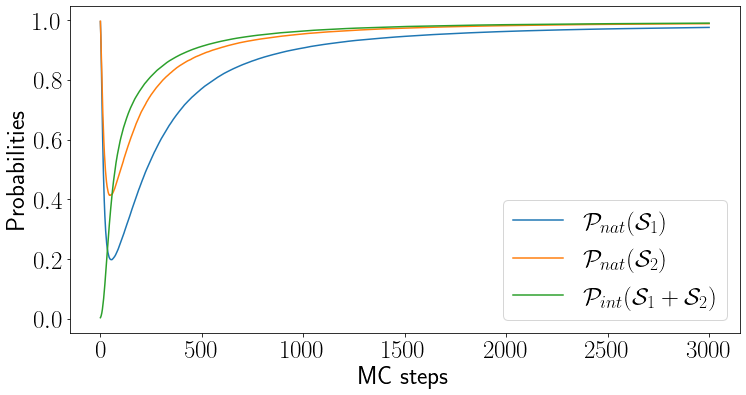

In [5]:
fig,ax = plt.subplots(ncols=1,nrows=1,figsize=(12,6))
plt.rcParams.update({'font.size':25})
plt.rc('text', usetex=True)

data = np.loadtxt('./data/MeanEvolution_mean_beta_1_gamma_5.0_struct_a624_b6682.txt')
ax.plot(data[:,0], data[:,1], label = r'$\mathcal{P}_{nat} ( \mathcal{S}_1 )$')
ax.plot(data[:,0], data[:,2], label = r'$\mathcal{P}_{nat} ( \mathcal{S}_2 )$')
ax.plot(data[:,0], data[:,3], label = r'$\mathcal{P}_{int} ( \mathcal{S}_1 + \mathcal{S}_2 )$')
ax.set_xlabel('MC steps')
ax.set_ylabel('Probabilities')
ax.legend()

#### Visualize the dimer in 3d space

In [ ]:
def mirror_point(triplets):
    a=1
    b,c,d = 0,0,0
    new_triplets = []
    for tmp_coord in triplets:
        x1,y1,z1 = tmp_coord          
        k =(-a * x1)/float((a * a))
        x2 = a * k + x1
        x3 = 2 * x2-x1
        y3,z3 = y1,z1
        new_triplets.append([x3,y3,z3])
    
    return np.array(new_triplets)

In [ ]:
coord = np.loadtxt('./src/coord10000.dat',dtype='int') ### load coordinates in space of all structures in the dataset
coord=coord.reshape((10000,27,3))

%matplotlib inline
fig = plt.figure(figsize=(20,20)) 

ax1 = fig.add_subplot(121, projection='3d')

triplets=coord[s1]
new_triplets = mirror_point(triplets)
for i in range(27):
    ax1.scatter(new_triplets[i,0],new_triplets[i,1], new_triplets[i,2],s = 50,edgecolor='b',facecolor='b',lw=2)
    ax1.text(new_triplets[i,0], new_triplets[i,1], new_triplets[i,2], '%s' %(str(i+1)),size=15, zorder=1,ha='left',va='bottom',color='red')
    if (i<26):

        x=np.array([new_triplets[i,0],new_triplets[i+1,0]])
        y=np.array([new_triplets[i,1],new_triplets[i+1,1]])
        z=np.array([new_triplets[i,2],new_triplets[i+1,2]])
        ax1.plot(x,y,z,"k--",lw=3)

ax2 = fig.add_subplot(122, projection='3d')
        
triplets=coord[s2]

for i in range(27):
    ax2.scatter(triplets[i,0],triplets[i,1], triplets[i,2],s = 50,edgecolor='b',facecolor='b',lw=2)
    ax2.text(triplets[i,0], triplets[i,1], triplets[i,2], '%s' %(str(i+1)),size=15, zorder=1,ha='left',va='bottom',color='red')
    if (i<26):

        x=np.array([triplets[i,0],triplets[i+1,0]])
        y=np.array([triplets[i,1],triplets[i+1,1]])
        z=np.array([triplets[i,2],triplets[i+1,2]])
        ax2.plot(x,y,z,"k--",lw=3)
        
#ax1.grid(True); ax2.grid(False)
#ax1.set_xticks([])
#ax1.set_yticks([])
#ax1.set_zticks([])
#ax2.set_xticks([])
#ax2.set_yticks([])
#ax2.set_zticks([])

ax1.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax1.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax1.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax1.w_xaxis.line.set_color((1.0, 1.0, 1.0, 0.0))
ax1.w_yaxis.line.set_color((1.0, 1.0, 1.0, 0.0))
ax1.w_zaxis.line.set_color((1.0, 1.0, 1.0, 0.0))

ax2.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax2.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax2.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax2.w_xaxis.line.set_color((1.0, 1.0, 1.0, 0.0))
ax2.w_yaxis.line.set_color((1.0, 1.0, 1.0, 0.0))
ax2.w_zaxis.line.set_color((1.0, 1.0, 1.0, 0.0))


plt.show()